#Demo Notebook — Three Common Problems in Regression and How to Fix Them
**Outliers • Overfitting • Explainability**

This demo notebook contains **three small regression examples** (10–20 data points each) designed for classroom visualization and intuition-building.

**Goals**
1. Show how **outliers** can distort regression fits and how to detect influential points.  
2. Show how **overfitting** happens and why regularization / model complexity control matters.  
3. Show why **explainability** requires putting features on comparable scales (standardization + beta weights).  


In [1]:
# === Imports ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error

np.set_printoptions(precision=4, suppress=True)


## Helper functions
We use a few helper functions for:  
- fitting OLS models (with intercept)  
- computing Cook’s Distance and leverage  
- plotting regression lines/curves  


In [2]:
def fit_ols_diagnostics(X, y):
    """Fit OLS and return (model, diagnostics dataframe).

    Parameters
    ----------
    X : array-like, shape (n,) or (n, p)
        Feature matrix (without intercept column).
    y : array-like, shape (n,)
        Target vector.
    """
    X = np.asarray(X)
    y = np.asarray(y).reshape(-1)
    if X.ndim == 1:
        X = X.reshape(-1, 1)

    # Add intercept column for statsmodels
    X_sm = sm.add_constant(X)
    model = sm.OLS(y, X_sm).fit()

    infl = OLSInfluence(model)
    diag = pd.DataFrame({
        "y": y,
        "y_hat": model.fittedvalues,
        "residual": model.resid,
        "leverage_hii": infl.hat_matrix_diag,   # diagonal of Hat matrix H
        "cooks_D": infl.cooks_distance[0]
    })
    return model, diag


def plot_line_fit(x, y, model, title=""):
    """Scatter + fitted line for 1D x."""
    x = np.asarray(x).reshape(-1)
    order = np.argsort(x)

    plt.figure(figsize=(7, 4))
    plt.scatter(x, y)
    x_sorted = x[order]

    X_sm = sm.add_constant(x_sorted)
    yhat_sorted = model.predict(X_sm)
    plt.plot(x_sorted, yhat_sorted)

    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()


def plot_curve_fit(x, y, pipeline, title=""):
    """Scatter + fitted curve for scikit-learn pipeline (1D x)."""
    x = np.asarray(x).reshape(-1, 1)
    y = np.asarray(y).reshape(-1)

    # Create a smooth grid for plotting
    grid = np.linspace(x.min(), x.max(), 200).reshape(-1, 1)
    yhat = pipeline.predict(grid)

    plt.figure(figsize=(7, 4))
    plt.scatter(x, y)
    plt.plot(grid, yhat)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()


# 1) Problem: Outliers (DV vs IV)  
Outliers are problematic in regression because OLS minimizes **squared error**, so one extreme point can dominate the fit.

In this example (12 points), we add one suspicious point and use **Cook’s Distance** to detect whether it is influential.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     97.89
Date:                Sun, 25 Jan 2026   Prob (F-statistic):           1.75e-06
Time:                        21:22:02   Log-Likelihood:                -28.783
No. Observations:                  12   AIC:                             61.57
Df Residuals:                      10   BIC:                             62.54
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.7076      1.796     -0.951      0.3

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=12 observations were given.
  return hypotest_fun_in(*args, **kwds)


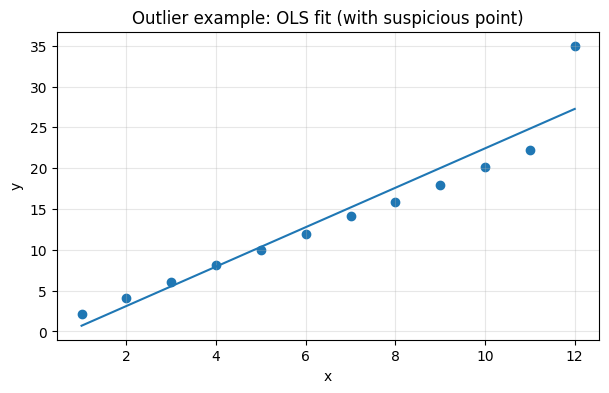

Cook's distance heuristic threshold 4/n = 0.333


,y,y_hat,residual,leverage_hii,cooks_D,x,flag_D_gt_4_over_n
11,35.0,27.260256,7.739744,0.294872,2.086624,12.0,True
10,22.2,24.846270,-2.646270,0.224942,0.154015,11.0,False
9,20.1,22.432284,-2.332284,0.168998,0.078187,10.0,False
0,2.2,0.706410,1.493590,0.294872,0.077706,1.0,False
8,18.0,20.018298,-2.018298,0.127040,0.039885,9.0,False
7,15.8,17.604312,-1.804312,0.099068,0.023338,8.0,False
1,4.1,3.120396,0.979604,0.224942,0.021106,2.0,False
6,14.2,15.190326,-0.990326,0.085082,0.005855,7.0,False
2,6.1,5.534382,0.565618,0.168998,0.004599,3.0,False
5,11.9,12.776340,-0.876340,0.085082,0.004585,6.0,False


In [3]:
# --- Example 1: Small dataset with one influential outlier (DV+IV style) ---
x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype=float)
y = np.array([2.2, 4.1, 6.1, 8.2, 10.0, 11.9, 14.2, 15.8, 18.0, 20.1, 22.2, 35.0], dtype=float)
# The last point has an unusually large y value compared to the trend.

model_full, diag_full = fit_ols_diagnostics(x, y)

print(model_full.summary())
plot_line_fit(x, y, model_full, title="Outlier example: OLS fit (with suspicious point)")

# Show the top points by Cook's distance
n = len(x)
threshold = 4 / n
diag_table = diag_full.copy()
diag_table["x"] = x
diag_table["flag_D_gt_4_over_n"] = diag_table["cooks_D"] > threshold

print(f"Cook's distance heuristic threshold 4/n = {threshold:.3f}")
diag_table.sort_values("cooks_D", ascending=False)


### Remove the most influential point and refit  
We remove the point with the largest Cook’s Distance and compare the fitted line before vs. after removal.


Full-data:   b0 = -1.7076, b1 = 2.4140
Cleaned-data: b0 = 0.1218, b1 = 1.9918


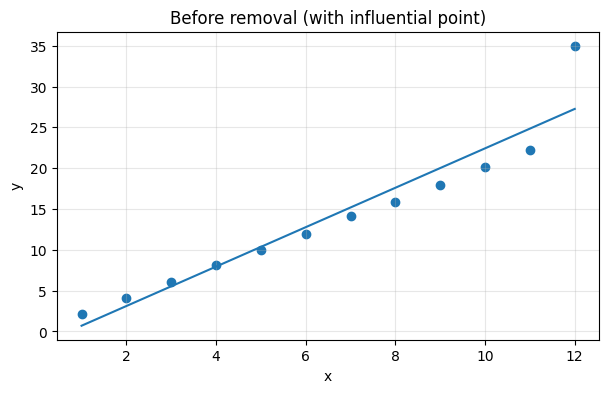

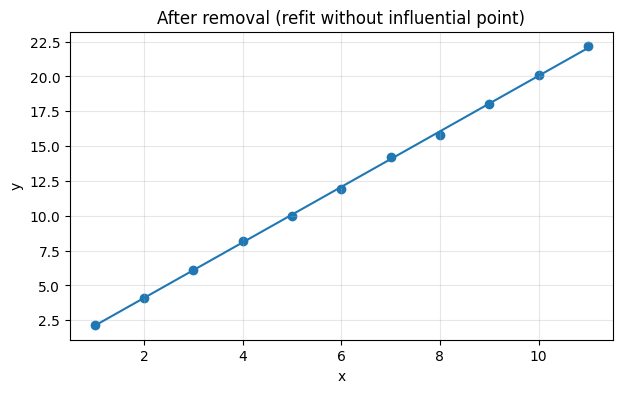

In [4]:
# Remove the most influential point (highest Cook's D)
idx_remove = diag_full["cooks_D"].idxmax()

x_clean = np.delete(x, idx_remove)
y_clean = np.delete(y, idx_remove)

model_clean, diag_clean = fit_ols_diagnostics(x_clean, y_clean)

coef_full = np.asarray(model_full.params).reshape(-1)
coef_clean = np.asarray(model_clean.params).reshape(-1)

print(f"Full-data:   b0 = {coef_full[0]:.4f}, b1 = {coef_full[1]:.4f}")
print(f"Cleaned-data: b0 = {coef_clean[0]:.4f}, b1 = {coef_clean[1]:.4f}")

plot_line_fit(x, y, model_full, title="Before removal (with influential point)")
plot_line_fit(x_clean, y_clean, model_clean, title="After removal (refit without influential point)")


**Takeaway:**  
- **Studentized residuals** highlight DV-type outliers (unusual **y**).  
- **Leverage** \(h_{ii}\) highlights IV-type outliers (unusual **x**).  
- **Cook’s Distance** flags points that significantly **change the fitted model** (influential points).  


# 2) Problem: Overfitting  
Overfitting happens when a model is too flexible and starts fitting **noise** instead of the underlying relationship.

In this example (15 points), we compare:  
- a **simple linear regression** model  
- a **high-degree polynomial** model (very flexible)

We also use a small test set to check generalization.


In [5]:
# --- Example 2: Small dataset where a high-degree polynomial overfits ---
rng = np.random.default_rng(0)

x2 = np.linspace(-3, 3, 15)
# True relationship is mildly nonlinear, plus noise
y2 = 2.0 + 1.2*x2 - 0.6*(x2**2) + rng.normal(0, 0.7, size=len(x2))

# Train/test split (small, for demonstration)
test_idx = np.array([2, 7, 12])  # choose a few points as "test"
train_idx = np.array([i for i in range(len(x2)) if i not in test_idx])

X_train = x2[train_idx].reshape(-1, 1)
y_train = y2[train_idx]
X_test = x2[test_idx].reshape(-1, 1)
y_test = y2[test_idx]

# Simple model (degree 1)
lin_model = Pipeline([
    ("poly", PolynomialFeatures(degree=1, include_bias=False)),
    ("reg", LinearRegression())
])

# Very flexible model (degree 10)
poly10_model = Pipeline([
    ("poly", PolynomialFeatures(degree=10, include_bias=False)),
    ("reg", LinearRegression())
])

lin_model.fit(X_train, y_train)
poly10_model.fit(X_train, y_train)

# Training vs test MSE
train_mse_lin = mean_squared_error(y_train, lin_model.predict(X_train))
test_mse_lin = mean_squared_error(y_test, lin_model.predict(X_test))

train_mse_poly10 = mean_squared_error(y_train, poly10_model.predict(X_train))
test_mse_poly10 = mean_squared_error(y_test, poly10_model.predict(X_test))

pd.DataFrame({
    "Model": ["Linear (deg=1)", "Polynomial (deg=10)"],
    "Train MSE": [train_mse_lin, train_mse_poly10],
    "Test MSE": [test_mse_lin, test_mse_poly10],
})


,Model,Train MSE,Test MSE
0,Linear (deg=1),4.246169,4.062324
1,Polynomial (deg=10),0.000171,0.666288


### Visualize underfitting vs. overfitting  
A high-degree polynomial can match training points extremely well, but can behave badly between points and generalize poorly.


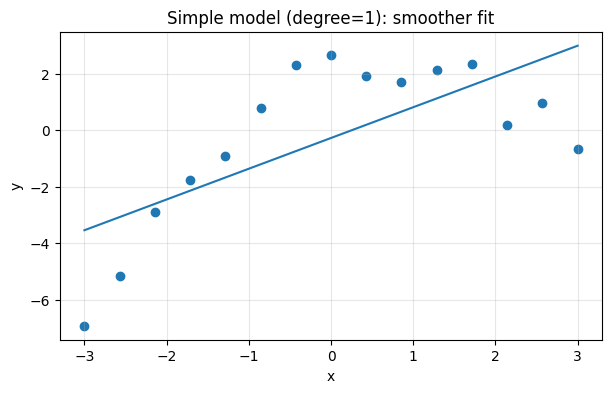

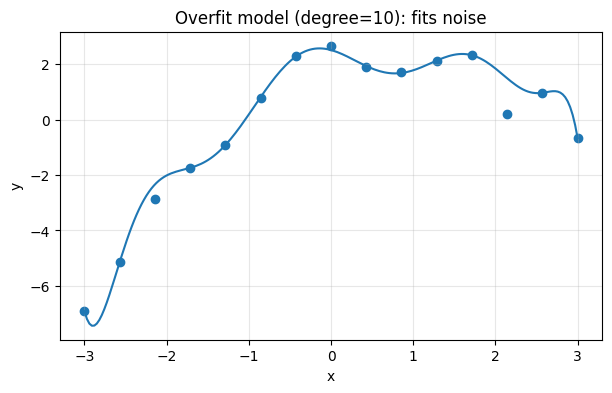

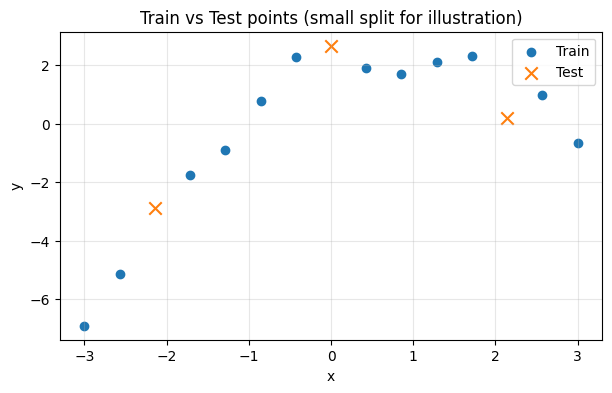

In [6]:
# Plot both fits on the full x-range
plot_curve_fit(x2, y2, lin_model, title="Simple model (degree=1): smoother fit")
plot_curve_fit(x2, y2, poly10_model, title="Overfit model (degree=10): fits noise")

# Highlight train vs test points
plt.figure(figsize=(7, 4))
plt.scatter(x2[train_idx], y2[train_idx], label="Train")
plt.scatter(x2[test_idx], y2[test_idx], label="Test", marker="x", s=80)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Train vs Test points (small split for illustration)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


### Mitigation idea: regularization (Ridge)  
Ridge regression penalizes large coefficients and reduces overfitting in flexible models.
We apply Ridge to the same degree-10 polynomial features.


In [7]:
# Degree-10 polynomial + Ridge (L2 regularization)
ridge_poly10 = Pipeline([
    ("poly", PolynomialFeatures(degree=10, include_bias=False)),
    ("reg", Ridge(alpha=10.0))  # larger alpha => stronger regularization
])

ridge_poly10.fit(X_train, y_train)

train_mse_ridge = mean_squared_error(y_train, ridge_poly10.predict(X_train))
test_mse_ridge = mean_squared_error(y_test, ridge_poly10.predict(X_test))

pd.DataFrame({
    "Model": ["Polynomial (deg=10) OLS", "Polynomial (deg=10) + Ridge"],
    "Train MSE": [train_mse_poly10, train_mse_ridge],
    "Test MSE": [test_mse_poly10, test_mse_ridge],
})


,Model,Train MSE,Test MSE
0,Polynomial (deg=10) OLS,0.000171,0.666288
1,Polynomial (deg=10) + Ridge,0.166117,2.322727


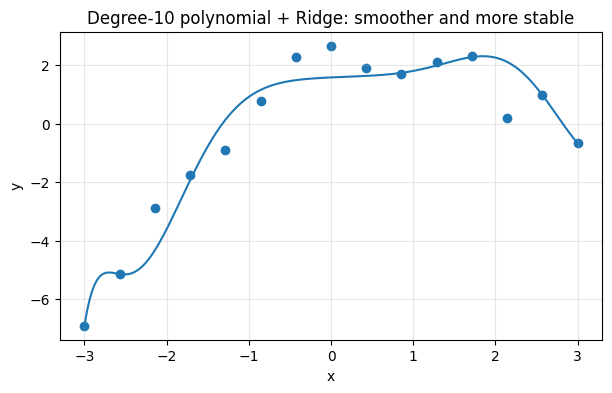

In [8]:
plot_curve_fit(x2, y2, ridge_poly10, title="Degree-10 polynomial + Ridge: smoother and more stable")


**Takeaway:**  
- Overfitting is a **high-variance** problem (model is too sensitive to the data).  
- Regularization (e.g., Ridge) reduces coefficient magnitude and improves generalization.  


# 3) Problem: Explainability (comparing feature effects)  
Raw regression coefficients are not directly comparable when features have **different units and scales**.

In this example (16 points), we use two features with very different scales:
- **Income** (tens of thousands)  
- **Age** (tens)

We compare:
1. raw coefficients \(b_j\)  
2. **standardized beta coefficients** \(\beta_j\), which are scale-free effect sizes  


In [9]:
# --- Example 3: Small multi-feature dataset for coefficient explainability ---
rng = np.random.default_rng(1)

n3 = 16
income = np.linspace(40_000, 160_000, n3)                    # large scale
age = np.linspace(22, 50, n3)                                # small scale

# Synthetic target: spending (in arbitrary units) + noise
y3 = 0.00012 * income + 1.8 * age + rng.normal(0, 3.0, size=n3)

X3 = np.column_stack([income, age])

# Fit OLS with intercept (statsmodels)
X3_sm = sm.add_constant(X3)
ols3 = sm.OLS(y3, X3_sm).fit()

print(ols3.summary())

b0, b_income, b_age = ols3.params
print("\nRaw coefficients:")
print(f"Intercept = {b0:.4f}")
print(f"b_income  = {b_income:.6f}  (units: y per $1)")
print(f"b_age     = {b_age:.4f}     (units: y per 1 year)")


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     1743.
Date:                Sun, 25 Jan 2026   Prob (F-statistic):           4.29e-16
Time:                        21:22:03   Log-Likelihood:                -31.712
No. Observations:                  16   AIC:                             67.42
Df Residuals:                      14   BIC:                             68.97
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1490      0.008     17.734      0.0

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=16 observations were given.
  return hypotest_fun_in(*args, **kwds)


### Standardized beta coefficients  
Standardized betas compare effects in **standard deviation units**:

$
\beta_j = b_j \cdot \frac{\sigma_{x_j}}{\sigma_y}
$

- $b_j$: raw coefficient for feature $x_j$  
- $\sigma_{x_j}$: standard deviation of that feature  
- $\sigma_y$: standard deviation of the target  


In [10]:
# Compute standardized betas using the conversion formula
sx_income = income.std(ddof=1)
sx_age = age.std(ddof=1)
sy = y3.std(ddof=1)

beta_income = b_income * (sx_income / sy)
beta_age = b_age * (sx_age / sy)

summary = pd.DataFrame({
    "Feature": ["income", "age"],
    "Raw coefficient b_j": [b_income, b_age],
    "Std(x_j)": [sx_income, sx_age],
    "Std(y)": [sy, sy],
    "Standardized beta β_j": [beta_income, beta_age],
    "|β_j|": [abs(beta_income), abs(beta_age)]
}).sort_values("|β_j|", ascending=False)

summary


,Feature,Raw coefficient b_j,Std(x_j),Std(y),Standardized beta β_j,|β_j|
1,age,1.887246,8.887111,20.316563,0.825541,0.825541
0,income,0.000091,38087.618286,20.316563,0.170467,0.170467


**Takeaway:**  
- Raw coefficients depend on feature units (dollars vs years).  
- Standardized betas are better for comparing **relative feature effect sizes** within the same regression model.  


# Summary
**Three common regression pitfalls**
1. **Outliers** can distort the fit → use leverage + residuals + Cook’s Distance to identify influential points.  
2. **Overfitting** reduces generalization → control complexity and/or use regularization (e.g., Ridge).  
3. **Explainability** needs fair comparison → use standardized features and standardized beta coefficients.  
